<a href="https://colab.research.google.com/github/rahul4070/fake-news-detection-project/blob/main/fake_news_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip - ‘glove.6B.zip’ saved [862182613/862182613]

In [2]:
!unzip glove.6B.zip

In [3]:
import tensorflow 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import joblib
import datetime
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()

In [5]:
df = pd.read_csv('/content/drive/MyDrive/fake_news/df_preprocessed.csv')
print(df.shape)
df.head()

(20800, 8)


,title,author,text,label,title_len,text_len,concat_title_text,concat_title_author
0,house dem aide even see comey letter jason cha...,darrell lucus,house dem aide even see comey letter jason cha...,1,10,444,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...
1,flynn hillary clinton big woman campus breitbart,daniel j flynn,ever get feeling life circle roundabout rather...,0,7,381,flynn hillary clinton big woman campus breitba...,flynn hillary clinton big woman campus breitba...
2,truth might get fired,consortiumnews com,truth might get fired october 29 2016 tension ...,1,4,710,truth might get fired truth might get fired oc...,truth might get fired consortiumnews com
3,15 civilian killed single u airstrike identified,jessica purkiss,video 15 civilian killed single u airstrike id...,1,7,321,15 civilian killed single u airstrike identifi...,15 civilian killed single u airstrike identifi...
4,iranian woman jailed fictional unpublished sto...,howard portnoy,print iranian woman sentenced six year prison ...,1,10,89,iranian woman jailed fictional unpublished sto...,iranian woman jailed fictional unpublished sto...


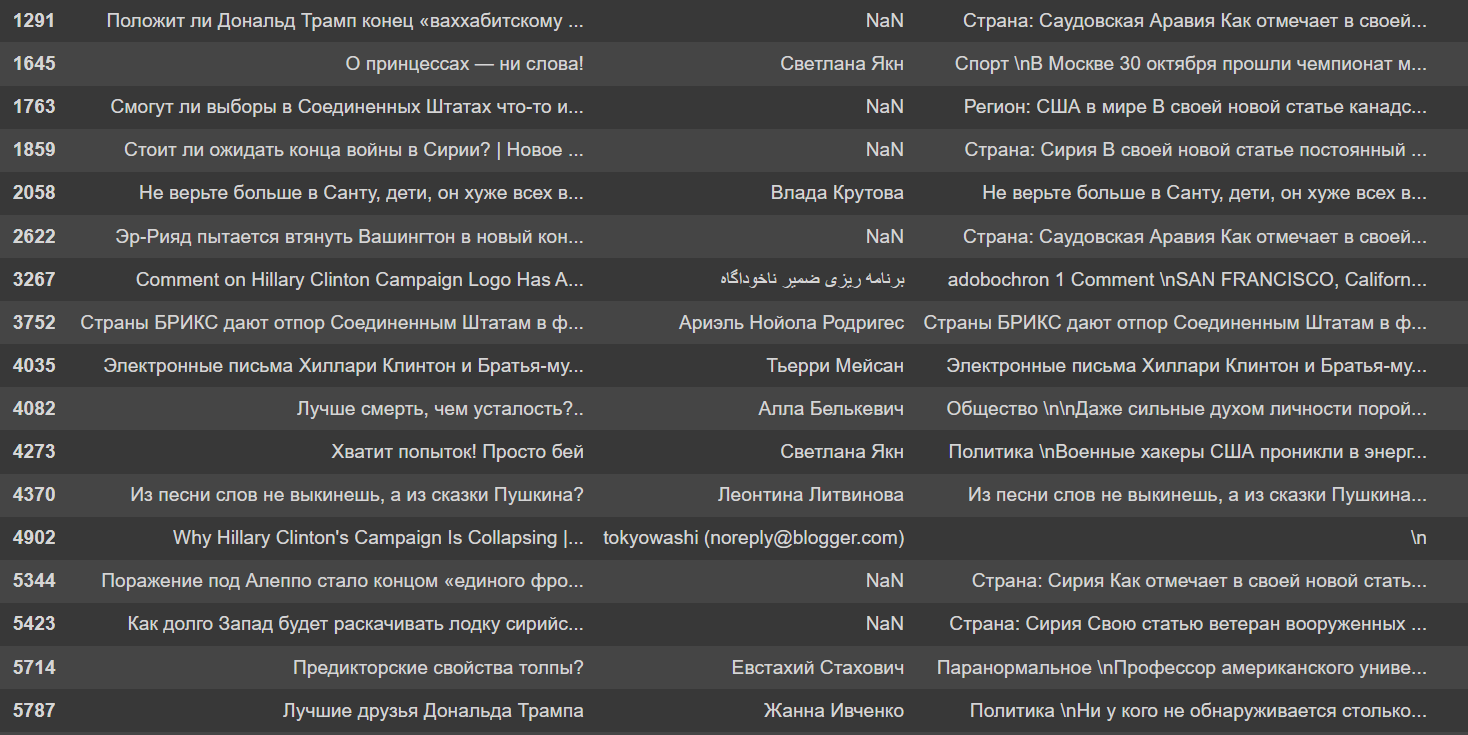

In [6]:
from IPython.display import Image
Image('/content/drive/MyDrive/fake_news/language.png')

Note: The above features shows some of the columns which contain foreign language and after preprocessing the rows these are left with empty rows, so filling the rows with unk_title, unk_text, unk_author.

In [7]:
df.title.fillna(' ', inplace=True)
df.text.fillna(' ', inplace=True)
df.author.fillna(' ', inplace=True)

In [8]:
df[df.isnull().any(axis=1)]

,title,author,text,label,title_len,text_len,concat_title_text,concat_title_author


In [9]:
df['title_author'] = df[['title', 'author']].progress_apply(lambda x: x[0] + ' ' + x[1], axis=1)
df['title_author_text'] = df[['title', 'author', 'text']].progress_apply(lambda x: x[0] + ' ' + x[1] + ' ' + ' '.join(x[2].split()[:100]), axis=1)

100%|██████████| 20800/20800 [00:00<00:00, 25892.13it/s]


In [10]:
df

,title,author,text,label,title_len,text_len,concat_title_text,concat_title_author,title_author,title_author_text
0,house dem aide even see comey letter jason cha...,darrell lucus,house dem aide even see comey letter jason cha...,1,10,444,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...
1,flynn hillary clinton big woman campus breitbart,daniel j flynn,ever get feeling life circle roundabout rather...,0,7,381,flynn hillary clinton big woman campus breitba...,flynn hillary clinton big woman campus breitba...,flynn hillary clinton big woman campus breitba...,flynn hillary clinton big woman campus breitba...
2,truth might get fired,consortiumnews com,truth might get fired october 29 2016 tension ...,1,4,710,truth might get fired truth might get fired oc...,truth might get fired consortiumnews com,truth might get fired consortiumnews com,truth might get fired consortiumnews com truth...
3,15 civilian killed single u airstrike identified,jessica purkiss,video 15 civilian killed single u airstrike id...,1,7,321,15 civilian killed single u airstrike identifi...,15 civilian killed single u airstrike identifi...,15 civilian killed single u airstrike identifi...,15 civilian killed single u airstrike identifi...
4,iranian woman jailed fictional unpublished sto...,howard portnoy,print iranian woman sentenced six year prison ...,1,10,89,iranian woman jailed fictional unpublished sto...,iranian woman jailed fictional unpublished sto...,iranian woman jailed fictional unpublished sto...,iranian woman jailed fictional unpublished sto...
...,...,...,...,...,...,...,...,...,...,...
20795,rapper trump poster child white supremacy,jerome hudson,rapper unloaded black celebrity met donald tru...,0,6,175,rapper trump poster child white supremacy rapp...,rapper trump poster child white supremacy jero...,rapper trump poster child white supremacy jero...,rapper trump poster child white supremacy jero...
20796,n f l playoff schedule matchup odds new york time,benjamin hoffman,green bay packer lost washington redskin week ...,0,10,612,n f l playoff schedule matchup odds new york t...,n f l playoff schedule matchup odds new york t...,n f l playoff schedule matchup odds new york t...,n f l playoff schedule matchup odds new york t...
20797,macy said receive takeover approach hudson bay...,michael j de la merced rachel abrams,macy today grew union several great name ameri...,0,10,472,macy said receive takeover approach hudson bay...,macy said receive takeover approach hudson bay...,macy said receive takeover approach hudson bay...,macy said receive takeover approach hudson bay...
20798,nato russia hold parallel exercise balkan,alex ansary,nato russia hold parallel exercise balkan 11 0...,1,6,180,nato russia hold parallel exercise balkan nato...,nato russia hold parallel exercise balkan alex...,nato russia hold parallel exercise balkan alex...,nato russia hold parallel exercise balkan alex...


In [11]:
X, y = df[['title_author', 'title_author_text']], df.label
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.08, random_state=23)

In [12]:
def text_to_sequences(train, test, file_name, training):
  '''
      function to perform text tokenizer 
      returns train_tokenizer and test_tokenizer
  '''

  if training:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train.astype(str))
    train_text = tokenizer.texts_to_sequences(train.astype(str))
    test_text  = tokenizer.texts_to_sequences(test.astype(str))
    joblib.dump(tokenizer, open('/content/drive/MyDrive/fake_news/Deep_learning/tokenizer/' + file_name , 'wb'))

    return train_text, test_text, tokenizer
  else:
    tokenizer = joblib.load(open('/content/drive/MyDrive/fake_news/Deep_learning/tokenizer/' + file_name , 'rb'))
    test_text = tokenizer.texts_to_sequences(test)
    return test_text


def text_padding(train, test, length, training):
  '''
      function to perform post-padding of sequences
      returns padding_train, padding_test
  '''
  
  if training:
    train = pad_sequences(train, maxlen=length, padding='pre')
    test  = pad_sequences(test,  maxlen=length, padding='pre')

    return train, test
  
  else:
    test_ = pad_sequences(test,  maxlen=length, padding='pre')
    
    return test_

In [13]:
# tokenizing the text data
x_train_author_token, x_test_author_token, author_tokenizer = text_to_sequences(x_train.title_author.values, x_test.title_author.values, 'title_author', True)
x_train_author_text_token, x_test_author_text_token, author_text_tokenizer = text_to_sequences(x_train.title_author_text.values, x_test.title_author_text.values, 'title_author_text', True)

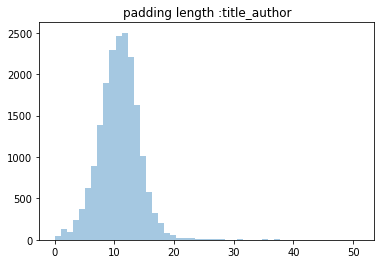

In [14]:
author_len = [len(x) for x in x_train_author_token]
sns.distplot(author_len, kde=False).set_title("padding length :"+ str('title_author'))
plt.show()

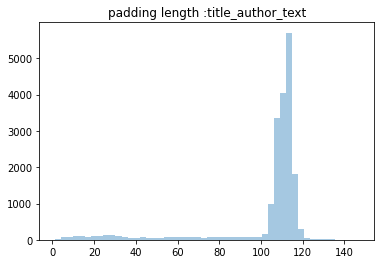

In [15]:
author_text_len = [len(x) for x in x_train_author_text_token]
sns.distplot(author_text_len, kde=False).set_title("padding length :"+ str('title_author_text'))
plt.show()

In [16]:
max_length_author = 20
max_length_author_text = 125

In [17]:
# padding the text data
x_train_author_padded, x_test_author_padded = text_padding(x_train_author_token, x_test_author_token, max_length_author, True)
x_train_author_text_padded, x_test_author_text_padded = text_padding(x_train_author_token, x_test_author_token, max_length_author_text, True)

In [18]:
# loading the glove vector
# embedding dictionary for key value pairs :- where keys are words and values are its vector representation
embedding_dict = dict()
f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embedding_dict[word] = coefs
f.close()


def create_embedding_matrix(tokenizer):
  '''
      this function creates a embedding vector for the embedding_layer
  '''
  
  # create a weight matrix for words in training docs
  embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
  for word, i in tokenizer.word_index.items():
      embedding_vector = embedding_dict.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [19]:
vocab_size_author = len(author_tokenizer.word_index) + 1
vocab_size_author_text = len(author_text_tokenizer.word_index) + 1

In [20]:
name_author_embedding = create_embedding_matrix(author_tokenizer)
name_author_text_embedding = create_embedding_matrix(author_text_tokenizer)

In [21]:
# creating embedding layer for name_brand_cat
embedding_layer_author = Embedding(
    vocab_size_author,
    100,
    embeddings_initializer=keras.initializers.Constant(name_author_embedding),
    trainable=False,
)

In [22]:
# creating embedding layer for name_brand_cat
embedding_layer_author_text = Embedding(
    vocab_size_author_text,
    100,
    embeddings_initializer=keras.initializers.Constant(name_author_text_embedding),
    trainable=False,
)

# Model with LSTM

In [23]:
def make_model():
    
    '''
        function to create a model
    '''
    
    # ******************************************Text embeddings****************************************************   
    #https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd 
    input_author = keras.Input(shape=(20, ), name="name_author")
    embedded_author = embedding_layer_author(input_author)
    lstm_author = layers.LSTM(100,kernel_initializer = 'glorot_uniform', return_sequences=True)(embedded_author)
    flatten_author = layers.Flatten()(lstm_author)
    
    input_author_text = keras.Input(shape=(125, ), name="name_author_text")
    embedded_author_text = embedding_layer_author_text(input_author_text)
    lstm_author_text = layers.LSTM(100)(embedded_author_text)
    flatten_author_text = layers.Flatten()(lstm_author_text)
    

    layer_ = layers.Concatenate()([flatten_author, flatten_author_text])
    
    dense = 256

    for i in range(2):
        layer_ = layers.Dropout(0.3)(layer_)
        layer_ = layers.Dense(units=dense, activation='tanh')(layer_)
        dense //= 2
    
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(layer_)
    
    # *******************************************creating model*****************************************************
    model = keras.Model(inputs=[input_author, input_author_text], \
                        outputs = output
                        )
    
    return model

In [24]:
model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name_author (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 name_author_text (InputLayer)  [(None, 125)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 100)      2110500     ['name_author[0][0]']            
                                                                                                  
 embedding_1 (Embedding)        (None, 125, 100)     6558300     ['name_author_text[0][0]']       
                                                                                              

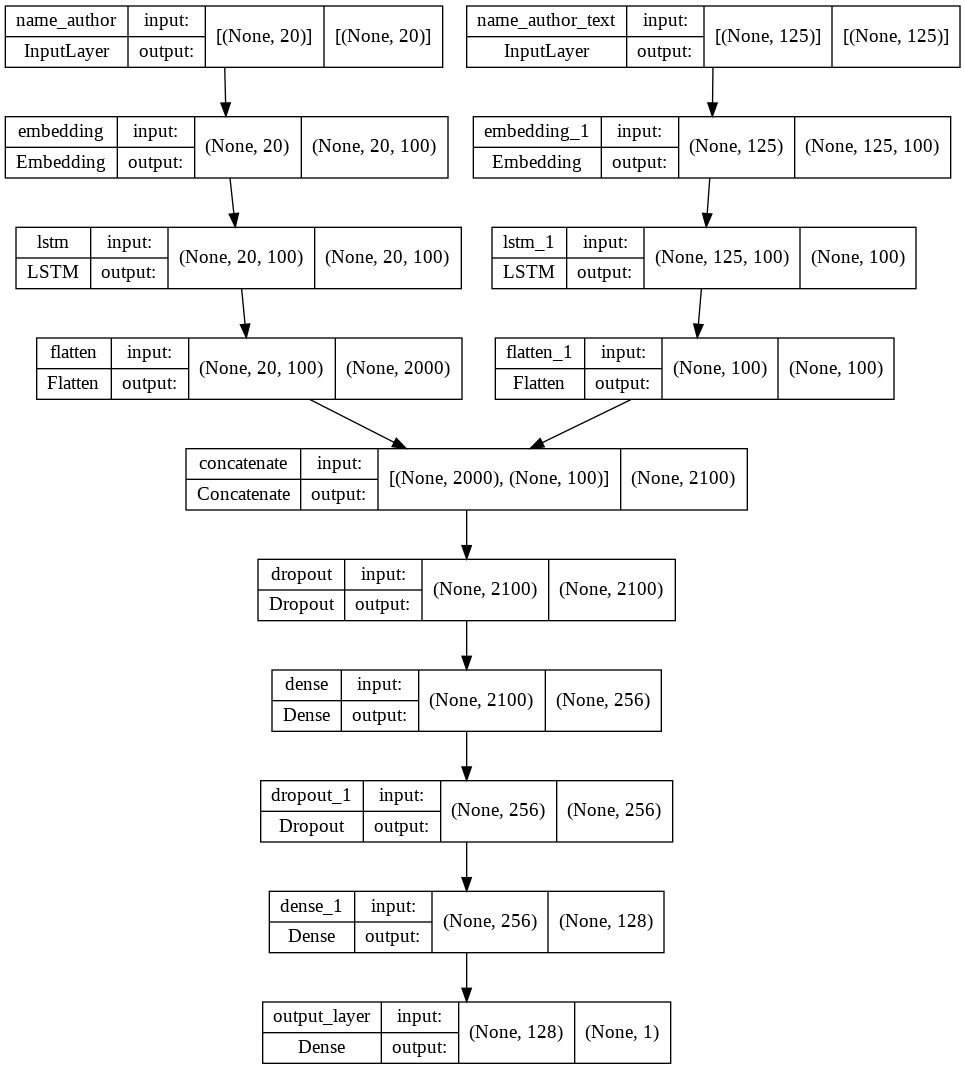

In [28]:
tensorflow.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=96)

In [29]:
X_train = [x_train_author_padded, x_train_author_text_padded]
X_test = [x_test_author_padded, x_test_author_text_padded]

In [30]:
X_train[0][0].shape

(20,)

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_history = model.fit(x=X_train, y=y_train, batch_size=1024, epochs=40, verbose=True, validation_data=(X_test, y_test), 
                           )

Epoch 1/40
19/19 [==============================] - 6s 99ms/step - loss: 0.3450 - accuracy: 0.8356 - val_loss: 0.2052 - val_accuracy: 0.9123
Epoch 2/40
19/19 [==============================] - 1s 42ms/step - loss: 0.1536 - accuracy: 0.9372 - val_loss: 0.1385 - val_accuracy: 0.9465
Epoch 3/40
19/19 [==============================] - 1s 43ms/step - loss: 0.0987 - accuracy: 0.9628 - val_loss: 0.1092 - val_accuracy: 0.9573
Epoch 4/40
19/19 [==============================] - 1s 42ms/step - loss: 0.0644 - accuracy: 0.9774 - val_loss: 0.0832 - val_accuracy: 0.9712
Epoch 5/40
19/19 [==============================] - 1s 43ms/step - loss: 0.0466 - accuracy: 0.9834 - val_loss: 0.0759 - val_accuracy: 0.9778
Epoch 6/40
19/19 [==============================] - 1s 42ms/step - loss: 0.0321 - accuracy: 0.9887 - val_loss: 0.0576 - val_accuracy: 0.9808
Epoch 7/40
19/19 [==============================] - 1s 43ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0498 - val_accuracy: 0.9856
Epoch 8/40
19

In [32]:
model.save('/content/drive/MyDrive/fake_news/Deep_learning/models/model_lstm.hdf5')

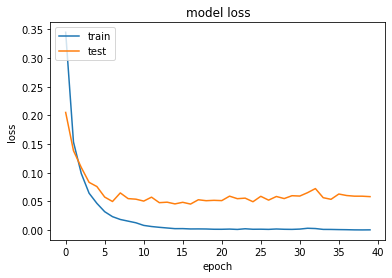

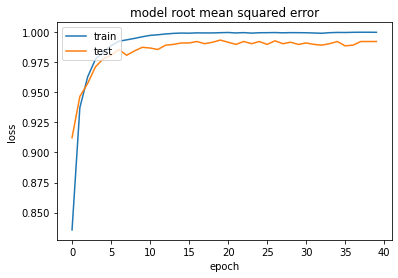

In [33]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model root mean squared error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model with CNN 



In [34]:
def model_cnn():
    
    '''
        function to create a model
    '''
    
    # ******************************************Text embeddings****************************************************  

    input_author = keras.Input(shape=(20, ), name="name_author")
    embedded_author = embedding_layer_author(input_author)
    conv_1d_author = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_author)
    max_pool_author = MaxPooling1D(pool_size=2)(conv_1d_author)
    flatten_author = layers.Flatten()(max_pool_author)
    

    input_author_text = keras.Input(shape=(125, ), name="name_author_text")
    embedded_author_text = embedding_layer_author_text(input_author_text)
    conv_1d_author_text = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_author_text)
    max_pool_author_text = MaxPooling1D(pool_size=2)(conv_1d_author_text)
    flatten_author_text = layers.Flatten()(max_pool_author_text)
    
    layer_ = layers.Concatenate()([flatten_author, flatten_author_text])
    
    dense = 256

    for i in range(2):
        layer_ = layers.Dropout(0.3)(layer_)
        layer_ = layers.Dense(units=dense, activation='relu')(layer_)
        dense //= 2
    
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(layer_)
    
    # *******************************************creating model*****************************************************
    model = keras.Model(inputs=[input_author, input_author_text], \
                        outputs = output
                        )
    
    return model

In [35]:
model = model_cnn()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name_author (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 name_author_text (InputLayer)  [(None, 125)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 100)      2110500     ['name_author[0][0]']            
                                                                                                  
 embedding_1 (Embedding)        (None, 125, 100)     6558300     ['name_author_text[0][0]']       
                                                                                            

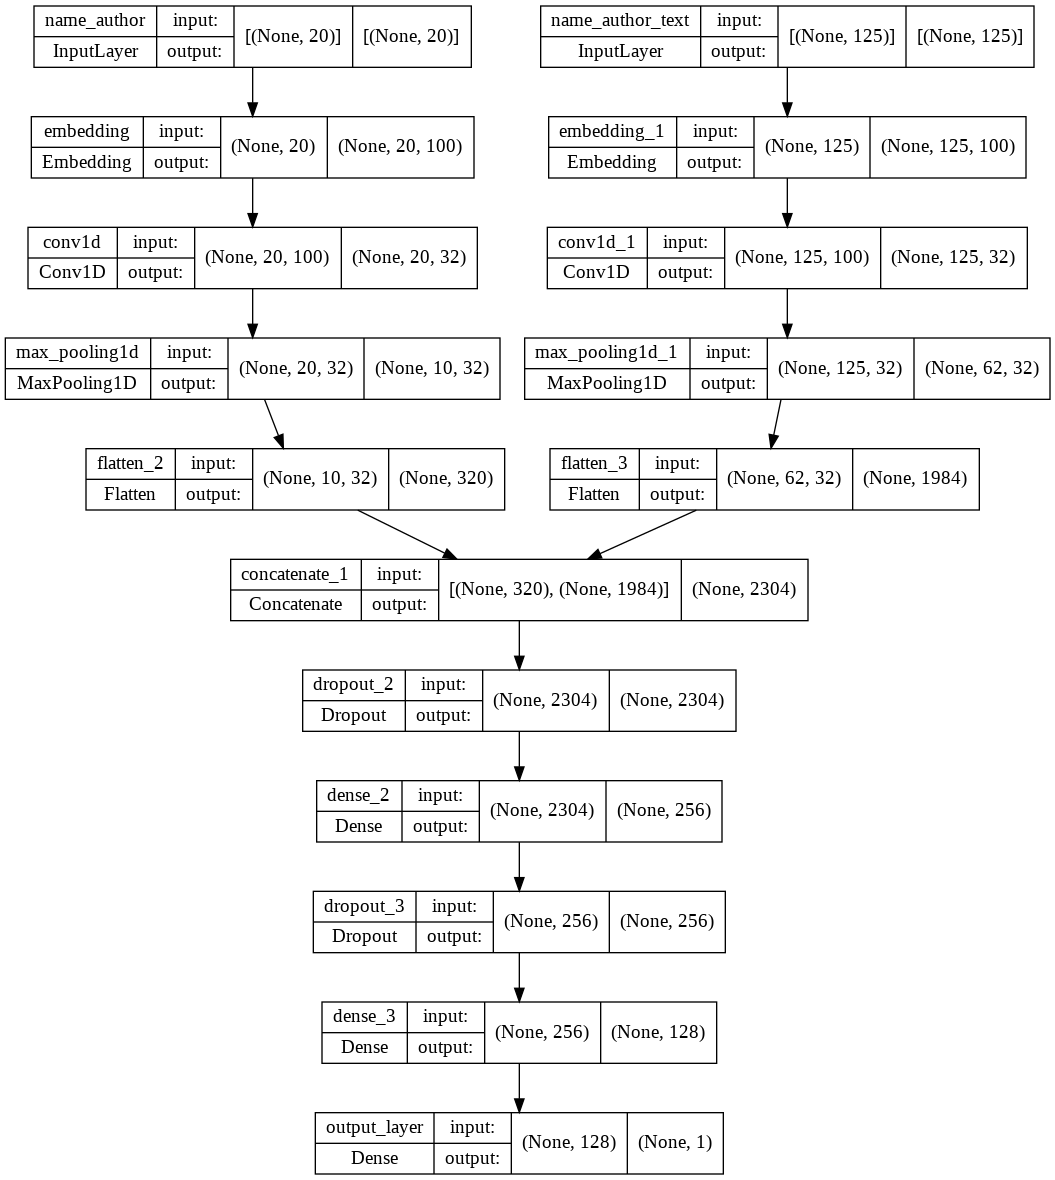

In [36]:
tensorflow.keras.utils.plot_model(model, to_file='model_cnn.png', show_shapes=True, dpi=96)

In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_history = model.fit(x=X_train, y=y_train, batch_size=1024, epochs=40, verbose=True, validation_data=(X_test, y_test), 
                           )

Epoch 1/40
19/19 [==============================] - 3s 32ms/step - loss: 0.4317 - accuracy: 0.7879 - val_loss: 0.2338 - val_accuracy: 0.8948
Epoch 2/40
19/19 [==============================] - 0s 13ms/step - loss: 0.1964 - accuracy: 0.9173 - val_loss: 0.1509 - val_accuracy: 0.9387
Epoch 3/40
19/19 [==============================] - 0s 13ms/step - loss: 0.1311 - accuracy: 0.9482 - val_loss: 0.1137 - val_accuracy: 0.9555
Epoch 4/40
19/19 [==============================] - 0s 13ms/step - loss: 0.0932 - accuracy: 0.9623 - val_loss: 0.0814 - val_accuracy: 0.9700
Epoch 5/40
19/19 [==============================] - 0s 13ms/step - loss: 0.0694 - accuracy: 0.9743 - val_loss: 0.0707 - val_accuracy: 0.9796
Epoch 6/40
19/19 [==============================] - 0s 14ms/step - loss: 0.0533 - accuracy: 0.9805 - val_loss: 0.0594 - val_accuracy: 0.9844
Epoch 7/40
19/19 [==============================] - 0s 14ms/step - loss: 0.0398 - accuracy: 0.9868 - val_loss: 0.0519 - val_accuracy: 0.9880
Epoch 8/40
19

In [38]:
model.save('/content/drive/MyDrive/fake_news/Deep_learning/models/model_cnn.hdf5')

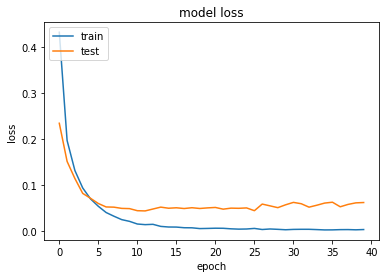

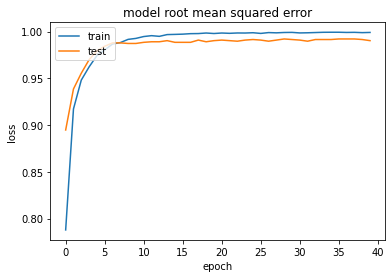

In [39]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model root mean squared error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model with CNN and LSTM

In [40]:
def model_lstm_cnn():
    
    '''
        function to create a model
    '''
    
    # ******************************************Text embeddings****************************************************  
    # CNN with LSTM
    #https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd

    input_author = keras.Input(shape=(20, ), name="name_author")
    embedded_author = embedding_layer_author(input_author)
    conv_1d_author = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_author)
    max_pool_author = MaxPooling1D(pool_size=2)(conv_1d_author)
    lstm_author = layers.LSTM(16,kernel_initializer = 'glorot_uniform', return_sequences=True)(max_pool_author)
    flatten_author = layers.Flatten()(lstm_author)

    input_author_text = keras.Input(shape=(125, ), name="name_author_text")
    embedded_author_text = embedding_layer_author_text(input_author_text)
    conv_1d_author_text = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedded_author_text)
    max_pool_author_text = MaxPooling1D(pool_size=2)(conv_1d_author_text)
    lstm_name_author_text = layers.LSTM(16,kernel_initializer = 'glorot_uniform', return_sequences=True)(max_pool_author_text)
    flatten_author_text = layers.Flatten()(lstm_name_author_text)

    layer_ = layers.Concatenate()([flatten_author, flatten_author_text])
    
    dense = 256

    for i in range(2):
        layer_ = layers.Dropout(0.3)(layer_)
        layer_ = layers.Dense(units=dense, activation='relu')(layer_)
        dense //= 2
    
    output = layers.Dense(1, activation='linear', name='output_layer')(layer_)
    
    # *******************************************creating model*****************************************************
    model = keras.Model(inputs=[input_author, input_author_text], \
                        outputs = output
                        )
    
    return model

In [41]:
model = model_lstm_cnn()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name_author (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 name_author_text (InputLayer)  [(None, 125)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 100)      2110500     ['name_author[0][0]']            
                                                                                                  
 embedding_1 (Embedding)        (None, 125, 100)     6558300     ['name_author_text[0][0]']       
                                                                                            

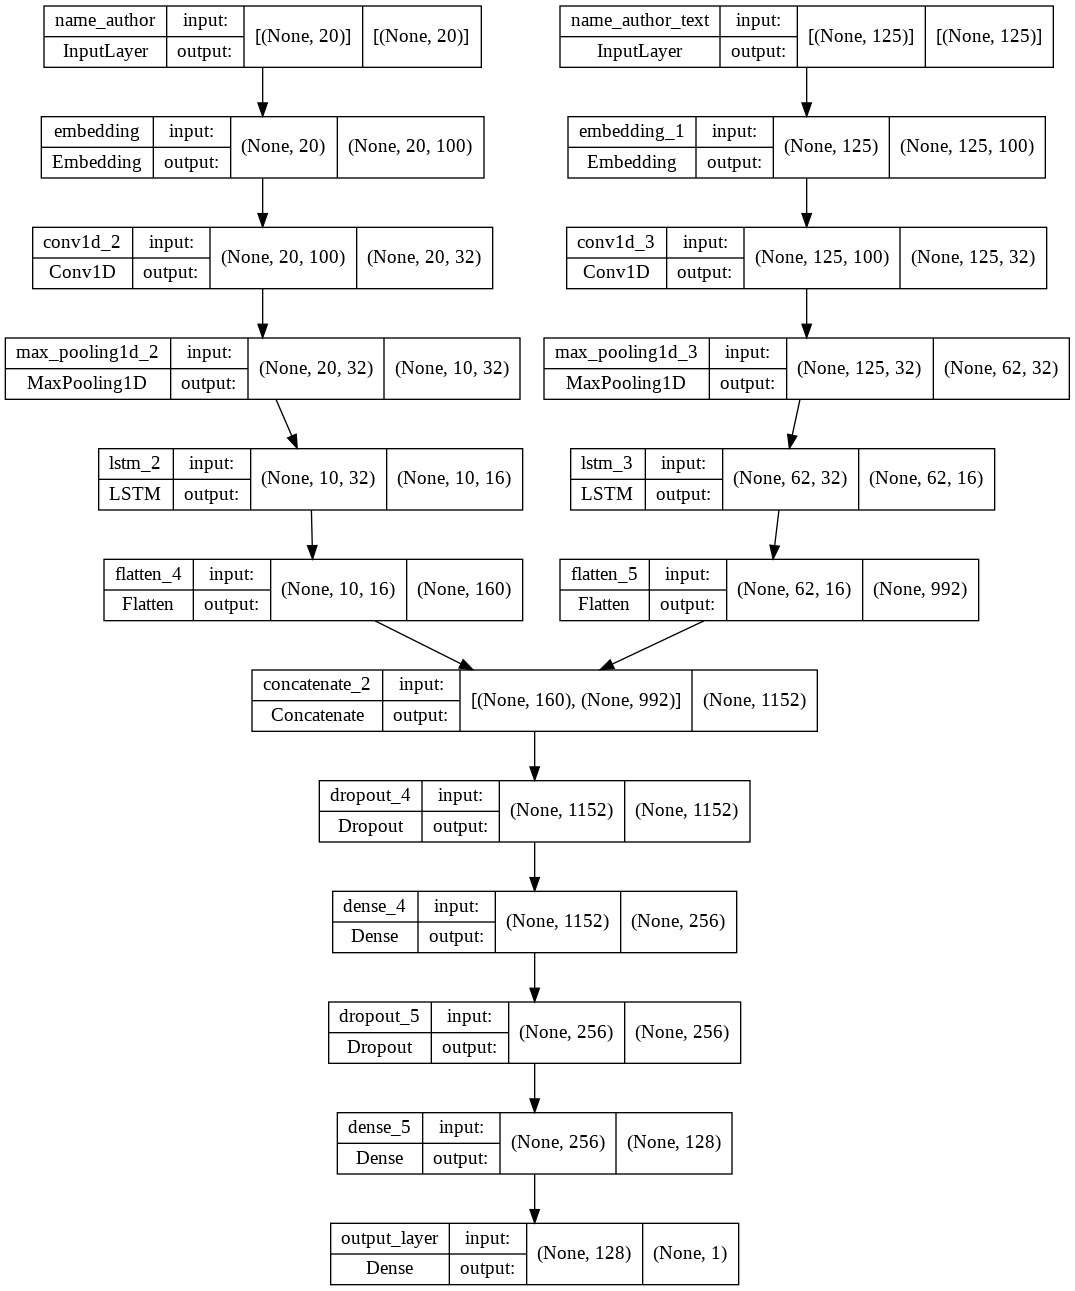

In [42]:
tensorflow.keras.utils.plot_model(model, to_file='model_cnn.png', show_shapes=True, dpi=96)

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_history = model.fit(x=X_train, y=y_train, batch_size=1024, epochs=50, verbose=True, validation_data=(X_test, y_test), 
                           )

Epoch 1/50
19/19 [==============================] - 4s 65ms/step - loss: 1.2379 - accuracy: 0.4736 - val_loss: 0.6384 - val_accuracy: 0.5883
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.5435 - accuracy: 0.7299 - val_loss: 0.5529 - val_accuracy: 0.6911
Epoch 3/50
19/19 [==============================] - 0s 17ms/step - loss: 0.4553 - accuracy: 0.7919 - val_loss: 0.4356 - val_accuracy: 0.8263
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 0.3750 - accuracy: 0.8661 - val_loss: 0.3639 - val_accuracy: 0.8708
Epoch 5/50
19/19 [==============================] - 0s 17ms/step - loss: 0.3201 - accuracy: 0.8947 - val_loss: 0.3406 - val_accuracy: 0.8924
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.2834 - accuracy: 0.9050 - val_loss: 0.2735 - val_accuracy: 0.8846
Epoch 7/50
19/19 [==============================] - 0s 17ms/step - loss: 0.2440 - accuracy: 0.9108 - val_loss: 0.2803 - val_accuracy: 0.9075
Epoch 8/50
19

In [44]:
model.save('/content/drive/MyDrive/fake_news/Deep_learning/models/model_lstm_cnn.hdf5')

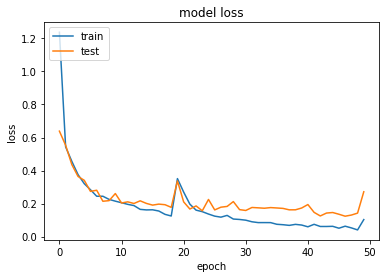

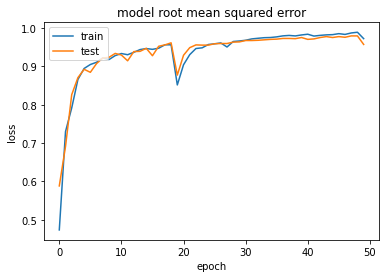

In [45]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model root mean squared error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()